In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import phate
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering")

from celldyn_qc import QcControl

%matplotlib inline


In [5]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [4]:
os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [5]:
meas_columns = [c for c in celldyn.columns if 'c_b' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn.columns if 'c_s_' in c.lower()]
celldyn = celldyn[meas_columns+mode_columns+alrt_columns+c_s_columns]
celldyn_full = celldyn[celldyn[meas_columns].isna().sum(axis=1)==0] # c_mode_cbc & c_mode_rtc are flagged

celldyn_full = QcControl.qc_rbc(celldyn_full)
celldyn_full = QcControl.qc_leuko(celldyn_full)
celldyn_full = QcControl.qc_standard_values(celldyn_full)

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [6]:
cut_offs = pd.read_csv("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\CelldynParams.csv",delimiter=";",encoding = 'latin-1')
col_names = cut_offs.columns
cut_offs = pd.DataFrame(np.where(cut_offs == '-',np.nan,cut_offs),columns=col_names)
print(len(celldyn_full))
for c in meas_columns:
    try:
        min_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Min'].iloc[0])
        max_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Max'].iloc[0])
        if c == 'c_b_ht':
            min_val*=100
            max_val*=100
        if not pd.isna(min_val):
            celldyn_full = celldyn_full.loc[lambda x:(x[c] <= max_val) & (x[c] >= min_val)]
            print(c, len(celldyn_full))
    except IndexError:
        print(c)



print(len(celldyn_full))

1990361
c_b_wbc 1990357
c_b_neu 1990306
c_b_seg 1990306
c_b_bnd 1990306
c_b_ig 1990306
c_b_lym 1990306
c_b_vlym 1990306
c_b_mon 1990302
c_b_blst 1990302
c_b_eos 1990302
c_b_bas 1990302
c_b_nrbc 1990180
c_b_pneu 1990180
c_b_pseg 1990180
c_b_pbnd 1990180
c_b_pig 1990180
c_b_plym 1990180
c_b_pvlym 1990180
c_b_pmon 1988863
c_b_pblst 1988863
c_b_peos 1988821
c_b_pbas 1988821
c_b_pnrbc 1986264
c_b_rbci 1986264
c_b_rbco 1986166
c_b_hgb_usa 1986118
c_b_mcv 1986102
c_b_rdw 1986092
c_b_pMIC 1986092
c_b_pMAC 1986092
c_b_mch_Usa 1986091
c_b_mchc_usa 1986040
c_b_ht 1974432
c_b_plto 1974384
c_b_plti 1974370
c_b_mpv 1973174
c_b_retc 1971986
c_b_rtcfmn
c_b_rtcfcv
c_b_hb 1971909
c_b_mch 1971909
c_b_mchc 1971909
1971909


### Alerts

In [3]:
celldyn_full = celldyn_full.loc[~np.any(celldyn_full[c_s_columns].isin([4,5]),axis = 1)]

NameError: name 'celldyn_full' is not defined

In [10]:
celldyn_full.to_csv("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\Data\data_no_c_s_45.csv")

###  log_transformers toevoegen

In [2]:
celldyn_full = pd.read_csv("L:/laupodteam/AIOS/Huibert-Jan/Celldynclustering/Data/data_no_c_s_45.csv")

In [3]:
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [6]:
droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']

final_columns = list(set(meas_columns)-set(droplist))


q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list)]

pre_transformer = ColumnTransformer(transformer_list,remainder = 'passthrough')


In [6]:
with open("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\sample_indices.txt",'r') as f:
    samples = [int(x) for x in f.read().split("\n")[:-1]]

In [ ]:
sample_df = celldyn_full.sample(50000)
print(len(sample_df))
reduce_dim = 6


embedder_full = phate.PHATE(n_components = 20, knn = 3,n_jobs = -3)
le_pipe = Pipeline([('scaler_1', pre_transformer),                    
                    ('scaler_2', StandardScaler())])

transformed_data = le_pipe.fit_transform(sample_df[meas_columns]) # final_columns

transformed_data = embedder_full.fit_transform(transformed_data)


50000
Calculating PHATE...
  Running PHATE on 50000 observations and 80 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 78.24 seconds.
    Calculating affinities...


Calculating KNN search...
Calculated KNN search in 0.85 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.


D:\Miniconda3\envs\embcelldyn\lib\site-packages\phate\phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


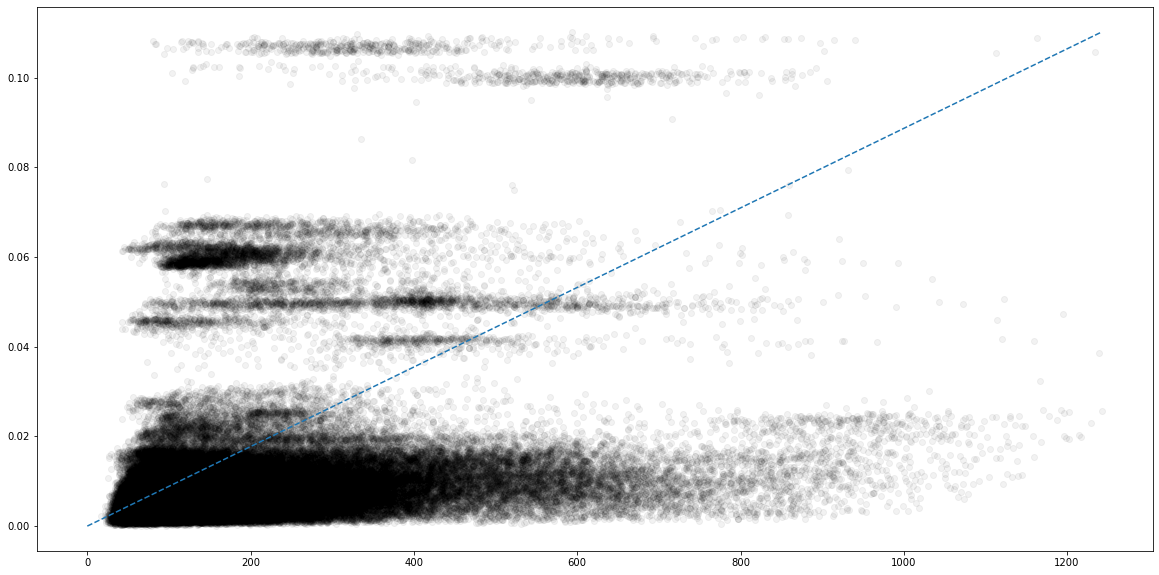

In [8]:
sample_selection = np.random.randint(0,100000,1000)

dist_df = sample_df.reset_index(drop = True)[meas_columns].loc[lambda x:x.index.isin(sample_selection)]

dist_before = distance.pdist(dist_df)
dist_after = distance.pdist(embedder_full.transform(le_pipe.transform(dist_df)))


plt.figure(figsize = (20,10))
plt.scatter(dist_before,dist_after, alpha = 0.05,c ='black')
mx,my = max(dist_before), max(dist_after)
plt.plot([0,mx],[0,my],ls = "--")

In [10]:
clusterer_embedding = KMeans(n_clusters = 5)
clusterer_embedding.fit(transformed_data)

KMeans(n_clusters=5)

In [11]:
clusterer_org_dat = KMeans(n_clusters = 5)
clusterer_org_dat.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))

KMeans(n_clusters=5)

In [13]:
r_score =rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
ar_score = adjusted_rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
mi_score = adjusted_mutual_info_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)

In [14]:
ch_score1 = calinski_harabasz_score(sample_df[meas_columns], clusterer_org_dat.labels_)
ch_score2 = calinski_harabasz_score(transformed_data, clusterer_embedding.labels_)

db_score1 = davies_bouldin_score(sample_df[meas_columns], clusterer_org_dat.labels_)
db_score2 = davies_bouldin_score(transformed_data, clusterer_embedding.labels_)

In [15]:
dist_preservation_overall = dcor.distance_correlation(dist_before, dist_after)

In [16]:
print("Distance preservation overall", dist_preservation_overall)
#print("Intra-distance trustworthiness", trustworthiness(sample_df[meas_columns], transformed_data))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)

Distance preservation overall 0.28207979174264425
Rand score 0.6888687861757236
Adjusted Rand score 0.39090539317441336
Adjusted MI score 0.3489006064855245
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.08365369438386253
David-Bouldin ratio, higher than 1 means better clustering for embedding 3.0379991144475915


In [17]:
plot_df = pd.DataFrame(data=transformed_data, columns=[f'd_{i}' for i in range(reduce_dim)], index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+alrt_columns+c_s_columns])
plot_df['k_means']  = clusterer_embedding.labels_
plot_df['has_alrt'] = np.where(np.sum(plot_df[alrt_columns],axis = 1) >0.5,1,0)
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil(reduce_dim**2/3))

plot_df.columns

Index(['d_0', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'c_mode_cbc', 'c_mode_rtc',
       'c_mode_cd61', 'c_mode_xLyse', 'c_mode_xCnt', 'c_mode', 'c_Alrt_rrbc',
       'c_Alrt_wbc', 'c_Alrt_dif', 'c_Alrt_wvf', 'c_Alrt_fp', 'c_Alrt_bnd',
       'c_Alrt_ig', 'c_Alrt_blst', 'c_Alrt_vlym', 'c_AlrtQ_bnd', 'c_AlrtQ_ig',
       'c_AlrtQ_blst', 'c_AlrtQ_vlym', 'c_AlrtQ_fp', 'c_Alrt_wbc_pltcmp',
       'c_Alrt_pltcmp2', 'c_Alrt_rbcDlta', 'c_Alrt_pltDlta', 'c_Alrt_rbc',
       'c_Alrt_plt', 'c_Alrt_hb', 'c_Alrt_rbc_assym', 'c_Alrt_rbc_pltCmp2',
       'c_Alrt_lri', 'c_Alrt_uri', 'c_Alrt_optlri', 'c_Alrt_opturi',
       'c_Alrt_retc', 'c_Alrt_retcHI', 'c_Alrt_retcIN', 'c_s_wbc', 'c_s_wvf',
       'c_s_neu', 'c_s_seg', 'c_s_bnd', 'c_s_ig', 'c_s_lym', 'c_s_lyme',
       'c_s_vlym', 'c_s_mon', 'c_s_mone', 'c_s_blst', 'c_s_eos', 'c_s_bas',
       'c_s_nrbc', 'c_s_pneu', 'c_s_pseg', 'c_s_pbnd', 'c_s_pig', 'c_s_plym',
       'c_s_plyme', 'c_s_pvlym', 'c_s_pmon', 'c_s_pmone', 'c_s_pblst',
       'c_s_peos', '

In [18]:
from sklearn.cluster import DBSCAN

sc = DBSCAN(eps=1)
sc.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))
plot_df['DBSCAN']=sc.labels_


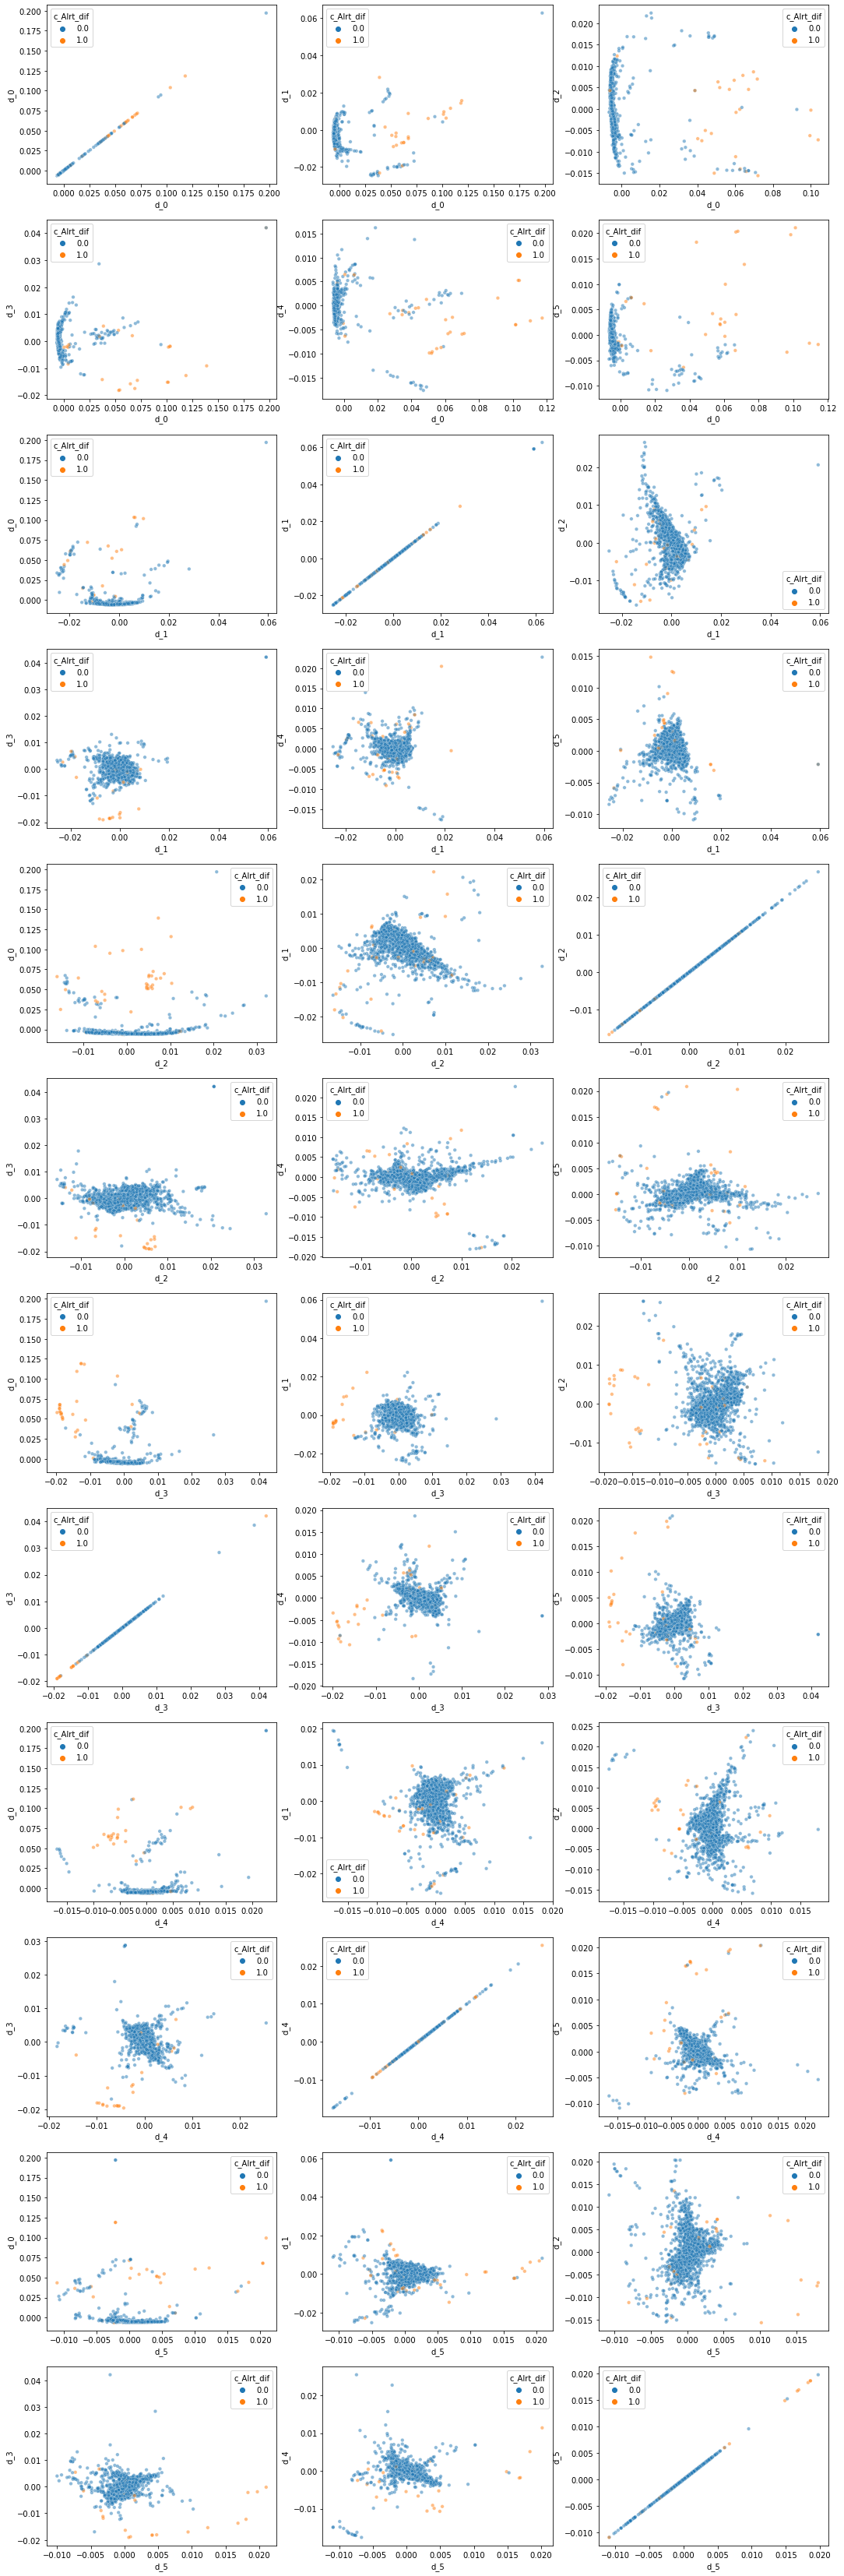

In [19]:
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue='c_Alrt_dif', alpha=0.5, s = 20)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue='c_Alrt_dif', alpha=0.5, s = 20)
        k += 1


